# attitude, wind estimation, LQG control, and gust response of a 10 mg aerial robot equipped with a camera and a 3-axis accelerometer 

Simulates robofly dynamics including stroke-averaged aerodynamic drag. Controller is LQG. 

States is a 3DOF state vector plus wind magnitude. Rotations are around the body y-axis, positions and velocities in world coordinates.

MIT License

Copyright (c) 2022 Sawyer B. Fuller and Zhitao Yu. 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from numpy import array, sin, cos
from scipy.io import loadmat

import control as ct

## constants

In [2]:
DT = 1./200
g = 9.81

## sensor modeling

### accelerometer
interpolate between robofly and fruit fly to get $b/m$ ratio of gnatbot

b_over_m_crazyflie = 0.44
b_over_m_robobee = 2.4691358024691357
b_over_m_drosophila = 10.0
coeffs = array([-0.3049635 , -1.91371319])
b_over_m_gnatbot = 4.939720945902159
b_gnatbot = 4.9397209459021594e-05
0.14753155532808024


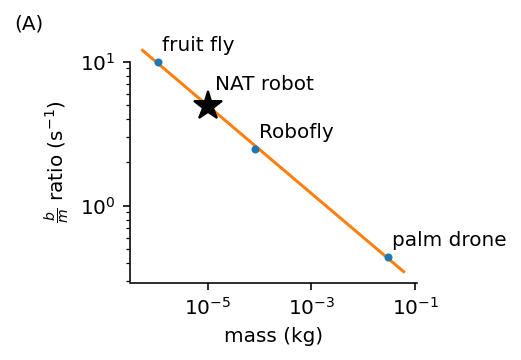

In [11]:
b_crazyflie = 13.2e-3 # [Ns/m]
m_crazyflie = 30e-3 # [kg]
b_over_m_crazyflie = b_crazyflie/m_crazyflie
print(f'{b_over_m_crazyflie = }')
m_robobee = 81e-6 # ma2013
b_robobee = 2e-4 # teoh2012
b_over_m_robobee = b_robobee/m_robobee
print(f'{b_over_m_robobee = }')
m_drosophila = 1.1e-6 # from fuller2014pnas [kg]
b_drosophila = 11e-6 # aero drag on wings, from fuller2014pnas [Ns/m]
b_over_m_drosophila = b_drosophila/m_drosophila
print(f'{b_over_m_drosophila = }')
m_array = (m_drosophila, m_robobee, m_crazyflie)
b_over_m_array = (b_over_m_drosophila, b_over_m_robobee, b_over_m_crazyflie)
labels = ('fruit fly', 'Robofly', 'palm drone')
plt.figure(figsize=(3.5,2.5))
plt.loglog(m_array, b_over_m_array, '.')
plt.xlabel('mass (kg)')
plt.ylabel(r'$\frac{b}{m}$ ratio (s$^{-1}$)');
for idx, m in enumerate(m_array):
    plt.text(m*1.2, b_over_m_array[idx]*1.2, labels[idx])

# fit exponential curve b_over_m = A m^B 
coeffs = np.polyfit(np.log(m_array), np.log(b_over_m_array), 1)
print(f'{coeffs = }')
m_points = np.logspace(np.log10(m_drosophila/2), np.log10(m_crazyflie*2))
b_over_m_points = np.exp(coeffs[1]) * m_points**coeffs[0]
#plt.loglog(m_points, np.exp(coeffs[1]) * np.exp(coeffs[0] * m_points))
plt.loglog(m_points, b_over_m_points, zorder=-20)
m_gnatbot = 10e-6
#b_over_m_gnatbot = b_over_m_drosophila - (b_over_m_drosophila - b_over_m_robobee)*(m_gnatbot - m_drosophila)/(m_robobee - m_drosophila)
b_over_m_gnatbot = np.exp(coeffs[1]) * m_gnatbot**coeffs[0]
print(f'{b_over_m_gnatbot = }')
b_gnatbot = b_over_m_gnatbot * m_gnatbot
print(f'{b_gnatbot = }')
plt.loglog(m_gnatbot, b_over_m_gnatbot, 'k*', markersize=15)
plt.text(m_gnatbot*1.4, b_over_m_gnatbot*1.3, 'NAT robot')
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((.3, 10))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.gcf().text(0,1, '(A)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('damping_scaling.pdf')
print(np.exp(coeffs[1]))

use $b/m$ ratio to calculate noise in accelerometer-based wind estimate

In [6]:
# datasheet numbers
crazyflie_asd_g = 175e-6 # amplitude spectral density [g/root Hz], from Bosch BMI088 IMU datasheet
gnatbot_sigma_g_100Hz = 4.4e-3 # standard deviation at 100Hz, lo-power mode. from mCube 3672 datsheet

# measured numbers
crazyflie_sigma_g_100Hz_inflight = 0.10663764897244526/g

# derived acceleration noise numbers at 100 Hz
crazyflie_sigma_g_100Hz = crazyflie_asd_g * np.sqrt(100) # [g]
print(f'{crazyflie_sigma_g_100Hz = }')
alpha = crazyflie_sigma_g_100Hz_inflight / crazyflie_sigma_g_100Hz 
print(f'{alpha = }') # factor increase in noise from datasheet due to flight

# derived acceleration noise numbers at control update rate 1/DT
crazyflie_sigma_ms2_200Hz_inflight = alpha * g * np.sqrt(1/DT/100) * crazyflie_sigma_g_100Hz
gnatbot_sigma_ms2_200Hz_inflight = alpha * g * np.sqrt(1/DT/100) * gnatbot_sigma_g_100Hz 
print(f'{crazyflie_sigma_ms2_200Hz_inflight = }')
print(f'{gnatbot_sigma_ms2_200Hz_inflight = }')

# derived airspeed measurement noise 
crazyflie_sigma_ms = crazyflie_sigma_ms2_200Hz_inflight * m_crazyflie/b_crazyflie
print(f'{crazyflie_sigma_ms = }')
gnatbot_sigma_ms = gnatbot_sigma_ms2_200Hz_inflight * m_gnatbot/b_gnatbot
print(f'{gnatbot_sigma_ms = }')

crazyflie_sigma_g_100Hz = 0.00175
alpha = 6.211600347892545
crazyflie_sigma_ms2_200Hz_inflight = 0.15080840943641347
gnatbot_sigma_ms2_200Hz_inflight = 0.3791754294401253
crazyflie_sigma_ms = 0.3427463850827579
gnatbot_sigma_ms = 0.07676049590507285


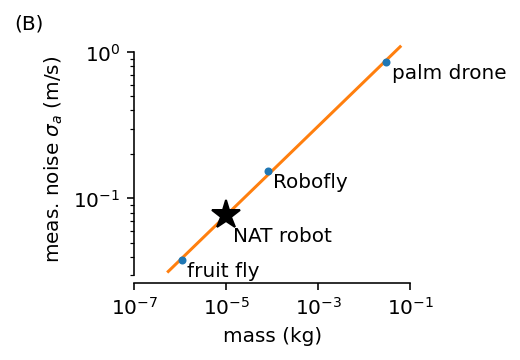

In [13]:
plt.figure(figsize=(3.5,2.5))
for idx, m in enumerate(m_array):
    plt.text(m*1.3, gnatbot_sigma_ms2_200Hz_inflight/b_over_m_array[idx]/1.3, labels[idx])
plt.loglog(m_array, gnatbot_sigma_ms2_200Hz_inflight /b_over_m_array, '.')
plt.loglog(m_points, gnatbot_sigma_ms2_200Hz_inflight/b_over_m_points, zorder=-20)
plt.loglog(m_gnatbot, gnatbot_sigma_ms2_200Hz_inflight/b_over_m_gnatbot, 'k*', markersize=15)
plt.text(m_gnatbot*1.4, gnatbot_sigma_ms2_200Hz_inflight/b_over_m_gnatbot/1.5, 'NAT robot')

plt.xlabel('mass (kg)')
plt.ylabel(r'meas. noise $\sigma_a$ (m/s)');
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((.03, 1))
ax.spines.bottom.set_bounds((1e-7, .1))
ax.xaxis.set_ticks((1e-7, 1e-5, 1e-3, 1e-1))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.gcf().text(0,1, '(B)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('noise_scaling.pdf')

slope: coeffs[0]*1e9 = 39.98655913978496 nW/pixel
predicted power usage of 35x35 pixel array =  48.98353494623657 uW


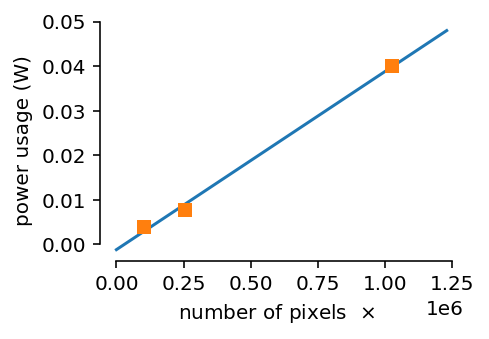

In [14]:
plt.figure(figsize=(3.5,2.5))
# Himax camera models: HM01B0, HM0361, HM11B1
npixels = np.array((320*320, 640*400, 1280*800))
powers = np.array((4, 7.8, 40))/1e3 #[W] # 60 Hz
coeffs = np.polyfit(npixels, powers, 1)
pixels_line = np.linspace(0, npixels[-1]*1.2)
plt.plot(pixels_line, np.poly1d(coeffs)(pixels_line))
plt.plot(npixels, powers, 's')
#plt.grid()
plt.xlabel(r'number of pixels  $\times$  ')
plt.ylabel('power usage (W)')
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((0, .05))
ax.spines.bottom.set_bounds((0, 1.25e6))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tight_layout()

plt.savefig('camera_scaling.pdf')
print(f'slope: {coeffs[0]*1e9 = } nW/pixel')
print('predicted power usage of 35x35 pixel array = ', coeffs[0]*35*35*1e6, 'uW')

now construct simulation

In [15]:
# gnat robot simulation parameters
class p: pass # struct-like for convenient access
p.h = 0.001 # height of body [m]
p.l = .004 # length of body [m]
p.m = m_gnatbot # mass [kg]
p.J = p.m * p.l**2 / 12 # J for a thin rod of length l [kgm^2]
p.b = b_gnatbot # aero drag on wings 
p.d_z = 0.0002 # z-distance from ctr of wings to ctr of mass [m]     
p.winglength = 4.6e-3 # [m]
p.c = (p.l/2 + p.winglength * 2./3)**2 * p.b   # rot drag coeff around y axis [Nsm]
p.pos_desired = (.1, .15) # [x_world, z_world]
p.sensor_noise_std = (gnatbot_sigma_ms, gnatbot_sigma_ms, 3) # [accel_x, accel_z, optic flow] 
print(f'{p.sensor_noise_std = }')

p.sensor_noise_std = (0.07676049590507285, 0.07676049590507285, 3)


#### Dynamics functions
The dynamics functions return the derivative at each time step. 

In [16]:
def cross(a, b): # fast, no tests on input
    return (a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1]-a[1]*b[0])

def aerodynamics(t, v_2D, thetadoty, p, R2=np.eye(2), v_wind=(0,0)):
    '''returns stroke-averaged forces due to aerodynamic drag on flapping wings
    in world coordinates. Assumes force is applied at point d_z away 
    from center of mass along body z-axis-direction.  
    drag force is linear: f_d = b_w * (v_wind - v_wings) = b_w * wings_airspeed
    Parameters: 
        v_2D: 2-vector (x, z) velocity of vehicle in world coordinates
        thetadoty: angular velocity around body y-vector
        R2: 2x2 rotation matrix for x,z coordinates
        t: time
    Returns
        f_d, tauy_d: force (x, z) and torque (y) in world coordinates
    '''
    d_z_2D = R2 @ (0, p.d_z) # vector from CM to center of drag in world coords
    d_z = (d_z_2D[0], 0, d_z_2D[1]) # y-component is zero when only in planar motion
    v = array((v_2D[0], 0, v_2D[1])) # "
    omega = array((0, thetadoty, 0)) # angular velocity vector
    v_wings = v + cross(omega, d_z) 
    airspeed_wings = (v_wind[0], 0, v_wind[1]) - v_wings
    f_d = p.b * airspeed_wings
    tauy_d = cross(d_z, f_d) - p.c * omega
    return (f_d[0], f_d[2]), tauy_d[1]

def R(theta): 
    "2D rot matrix, vworld = R @ vbody and vbody = R.T @ vworld"
    return array((( cos(theta), sin(theta)), 
                  (-sin(theta), cos(theta)))) 
    
def dynamics_model(t, q, u, p, v_wind=(0,0)):
    # u is m/s^2, rad/s^2, 
    thetay = q[0]
    thetadoty = q[1]
    v_world = q[[3, 5]]
    R2 = R(thetay)
    
    # forces in world frame [f_x, f_z]
    f_d, tauy_d = aerodynamics(t, v_world, thetadoty, p, R2, v_wind)
    f_g = array((0, -p.m * g)) # gravity
    f_c = R2 @ (0, u[0] + g) * p.m # control accel + baseline g thrust
    f = f_g + f_c + f_d

    # torques (body y-axis: [tau_y])
    tauy = u[1] * p.J + tauy_d 

    # calculate derivatives
    thetadotdoty = 1/p.J * (tauy - 0) # in 3D, J*thetadotdoty = tau - omega x J omega
    vdot = 1/p.m * f
    qdot = array((thetadoty, thetadotdoty, v_world[0], vdot[0], v_world[1], vdot[1], 0))
    return qdot

def zero_wind(t): 
    return (0,0)

def step_wind(t): 
    if t <=0: 
        return (0, 0)
    else: 
        return (0.1, 0)

# no-wind case
def nowind_dynamics_model(*args, **kwargs):
    return dynamics_model(*args, **kwargs)[:-1]

def ideal_ao_sensor_model(t, q, p, v_wind=(0,0), noisy=True):
    thetay = q[0]
    omegay = q[1]
    v_world = q[[3, 5]]
    z = q[4]
    R2 = R(thetay)
    v_body = R2.T @ v_world
    v_wind_body = R2.T @ v_wind
    
    x_airspeed = v_wind_body[0] - v_body[0]  + noisy*normal(0, p.sensor_noise_std[0])
    z_airspeed = v_wind_body[1] - v_body[1]  + noisy*normal(0, p.sensor_noise_std[1])
    OF =  omegay - v_body[0] * cos(thetay) / z + noisy*normal(0, p.sensor_noise_std[2])
    return (x_airspeed, z_airspeed, OF)

# no optic flow case
def ideal_a_sensor_model(*args, **kwargs):
    return ideal_ao_sensor_model(*args, **kwargs)[:-1]

# 1. Simulation of accelerometer-only (A) sensor suite

create linearized dynamics and observer model matrices

In [17]:
# states:[thetay,          omegay,    x,             vx, z,       vz]
A_a = array([[0,                1,    0,              0, 0,        0], # thetay
             [0,         -p.c/p.J,    0, -p.b*p.d_z/p.J, 0,        0], # omegay
             [0,                0,    0,              1, 0,        0], # x
             [g,   -p.b*p.d_z/p.m,    0,       -p.b/p.m, 0,        0], # vx
             [0,                0,    0,              0, 0,        1], # z
             [0,                0,    0,              0, 0, -p.b/p.m]])# vz
B_a = array([[0,     0], 
             [0,     1], 
             [0,     0],
             [0,     0], 
             [0,     0],
             [1,     0]])
C_a = array([[0,     0,  0,                  -1,   0,     0], # x-airspeed
             [0,     0,  0,                  0,   0,     -1]]) # z-airspeed

LQR controller

In [18]:
# state cost is your main tuning knob: increase it to slow down dynamics for a given state
#             [ty, tdoty,      x,  vx,       z,  vz]
QQ = np.diag([ 10,    10,    100,  10,     100,  10]) 
RR = np.diag([1, 1e-3]) # control cost [a_z, alpha_y]
K = ct.lqr(A_a, B_a, QQ, RR)[0]

def lqr_controller_a(q, p, t):
    q_desired = array((0, 0, p.pos_desired[0], 0, p.pos_desired[1], 0))     
    q_error = q_desired - q
    u = K @ q_error
    return u

Kalman filter/estimator

In [19]:
# accessory function to remove states from a dynamical system matrix
def delstates(ary, states):
    states = np.atleast_1d(states)[np.array(states).argsort()] # sort
    for state in states[::-1]: # go from high to low
        ary = np.delete(np.delete(ary, state, axis=0), state, axis=1)
    return ary

In [20]:
# A matrix with x and z is not observable:
print("full obsv matrix rank =", np.linalg.matrix_rank(ct.obsv(A_a, C_a)), ", A rank =", A_a.shape[0]) 

# this means we cannot construct a Kalman Filter to observe the. 
# solution: create a "reduced" linearized model that leaves out x and z
# old states in A:  [thetay,omegay, x, vx, z, vz]    
# new states in A_r:[thetay,omegay, vx, vz]    
A_ar = delstates(A_a, [2, 4])

# disturbance accel input matrix
#      d = [a_x,   a_z,   alpha_y] (i.e., forces and torques only)
G_ar = array([[0,     0,     0], 
           [0,     0,     1], 
           [1,     0,     0],
           [0,     1,     0]])
C_ar = np.delete(C_a, [2, 4], axis=1)

# check: sys observable if two ranks are same
print("reduced obsv matrix rank =", np.linalg.matrix_rank(ct.obsv(A_ar, C_ar)), ", A rank =", A_ar.shape[0]) 

# process noise is your tuning knob. increase it to rely more on sensors
#QN = np.diag((arr([1, 1, 100])/10)**2) # [a_x, a_z, alpha_y] process noise
#DEBUG: new
QN_a = np.diag((array([.1, .1, 10]))**2) # [a_x, a_z, alpha_y, vwd] process noise
RN_a = np.diag(p.sensor_noise_std[:2])**2 # sensor noise
L_a = ct.lqe(A_ar, G_ar, C_ar, QN_a, RN_a, method='scipy')[0]

# now create full estimator, which estimates x and z by numerically integrating vx, vz.
# the noisy velocity estimate and no correction means 
# there will be drift in x and z estimates
L_a = np.vstack((L_a[:2,:], # first two rows: ty, tdoty 
               [0,0], # x
               L_a[2:3,:], # vx
               [0,0], # z
               L_a[3:,:]))# vz
print(f'{L_a = }')

def estimator_dynamics_a(qhat, y, u=None):
    if u is None: 
        u = np.zeros(len(B[0]))
    return A_a @ qhat + B_a @ u + L_a @ (y - C_a @ qhat)

full obsv matrix rank = 4 , A rank = 6
reduced obsv matrix rank = 4 , A rank = 4
L_a = array([[-1.55091906e-01,  8.42839271e-17],
       [ 3.38483748e+00,  6.15907613e-16],
       [ 0.00000000e+00,  0.00000000e+00],
       [-4.59130858e-01,  2.78750410e-19],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.78750410e-19, -1.68900154e-01]])


simulate

In [21]:
def simulate(p=p, q=None, tfinal=10, 
             sensor_model=ideal_ao_sensor_model, 
             dynamics_model=dynamics_model,
             controller=lqr_controller_a, 
             estimator_dynamics=estimator_dynamics_a,
             wind_function=zero_wind, 
             use_estimator=True, noisy=True, perturb_qhat=True):
    # initial condition
    if q is None:
        #         [thetay, omegay,  x, vx,  z, vz, vw]
        q = array([     0,      0, .2,  0, .1,  0,  0]) 
    qhat = q.copy()
    if perturb_qhat: 
        # add error to initial state estimate
        qhat[2] += .005
        qhat[4] += .005
    u = array([0, 0])
    time = np.arange(0,tfinal,DT) 
    q_data = np.zeros((len(time), len(q)))
    u_data = np.zeros((len(time), 2))
    y_data = np.zeros((len(time), len(sensor_model(0, q, p))))
    qhat_data = np.zeros((len(time), len(q)))

    # simulate
    for idx, t in enumerate(time):
        y = sensor_model(t, q, p, wind_function(t), noisy=noisy)
        qhat += DT * estimator_dynamics(qhat, y, u)
        if use_estimator:
            u = controller(qhat, p, t)
        else:
            u = controller(q, p, t)
        u[0] = np.clip(u[0],-0.5*g, 0.5*g) # limit maximum accel
        q += DT * dynamics_model(t, q, u, p, wind_function(t))
        if len(q) > 6: q[-1] = wind_function(t)[0] # store wind velocity for analysis
        u_data[idx,:] = u
        q_data[idx,:] = q
        y_data[idx,:] = y
        qhat_data[idx,:] = qhat
    return time, q_data, u_data, y_data, qhat_data

def plotfly(x, z, theta, p, color='k'):
    h = p.l/2; v = p.h/2 
    points = array(((h, h, -h, -h, h), (v, -v, -v, v, v)))
    rotated_points = R(theta).T @ points 
    plt.plot(rotated_points[0,:] + x, rotated_points[1,:] + z, color=color, lw=1)

def plot_trajectory(p, time, q_data, u_data, y_data, qhat_data, figure_file=None):
    figlist = []
    # 2D
    figlist.append(plt.figure(figsize=(3.5,3)))
    plt.plot(q_data[::int(0.01/DT),2], q_data[::int(0.01/DT),4], 'k', lw=1, label='true') # trajectory
    plt.plot(qhat_data[::int(0.01/DT),2], qhat_data[::int(0.01/DT),4], 'grey', lw=1, label='estimate') # trajectory
    for q in qhat_data[::int(0.2/DT),:]: # rectangles
        plotfly(q[2], q[4], q[0], p, color='grey')
    for q in q_data[::int(0.2/DT),:]: # rectangles
        plotfly(q[2], q[4], q[0], p)
    plt.axis('equal')
    plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
    plt.axis([0.075, .21, .1-.01 , 0.175])
    plt.xlabel('x position (m)')
    plt.ylabel('z position (m)')
    plt.legend()
    ax = plt.gca()
    # Only draw spine between the y-ticks
    ax.spines.left.set_bounds((0.08, .18))
    ax.spines.bottom.set_bounds((.1, .2))
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    if figure_file is not None:
        plt.savefig(figure_file)
        
    #state traces
    figlist.append(plt.figure(figsize=(5,10)))
    ylabels = (r'$\theta$', r'$\dot\theta$', r'$x$', r"$v_x$", r'$z$', r"$v_z$", r"$v_{wx}$")
    n_q = len(q_data[0])
    for idx in range(n_q):
        plt.subplot(n_q,1,idx+1)
        plt.plot(time, qhat_data[:,idx], 'grey', time, q_data[:,idx], 'k')
        plt.ylabel(ylabels[idx])
        if idx == 0: plt.legend(('estimate', 'true'))
    # inputs
    figlist.append(plt.figure(figsize=(5,5)))
    ylabels = (r'$a_z$ (m/s$^2$)', r'$\alpha_y$ (rad/s$^2$)')
    plt.subplot(2,1,1)
    plt.plot(time, u_data[:,0], 'r')
    plt.axhline(0, c='k', ls='--', lw=1)
    plt.ylabel(ylabels[0])
    plt.subplot(2,1,2)
    plt.plot(time, u_data[:,1])
    plt.axhline(0, c='k', ls='--', lw=1)
    plt.ylabel(ylabels[1])
    # outputs
    figlist.append(plt.figure(figsize=(5,5)))
    ylabels = (r'$v_{am}$ (m/s)', r'$\Omega_m$ (rad/s)')
    if len(y_data[0]) > 2:
        plt.subplot(2,1,1)
    plt.plot(time, y_data[:,0:2])
    plt.axhline(0, c='k', ls='--', lw=1)
    plt.ylabel(ylabels[0])
    if len(y_data[0]) > 2:
        plt.subplot(2,1,2)
        plt.plot(time, y_data[:,2])
        plt.axhline(0, c='k', ls='--', lw=1)
        plt.ylabel(ylabels[1])
    return figlist

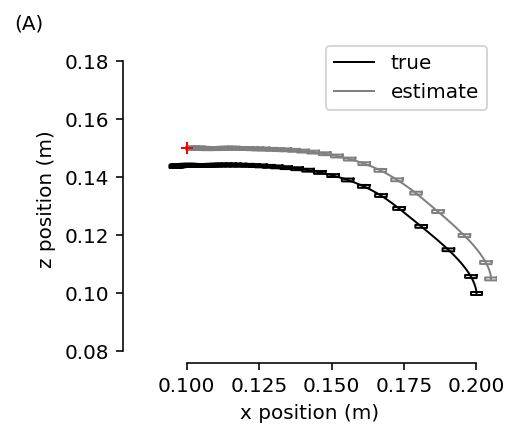

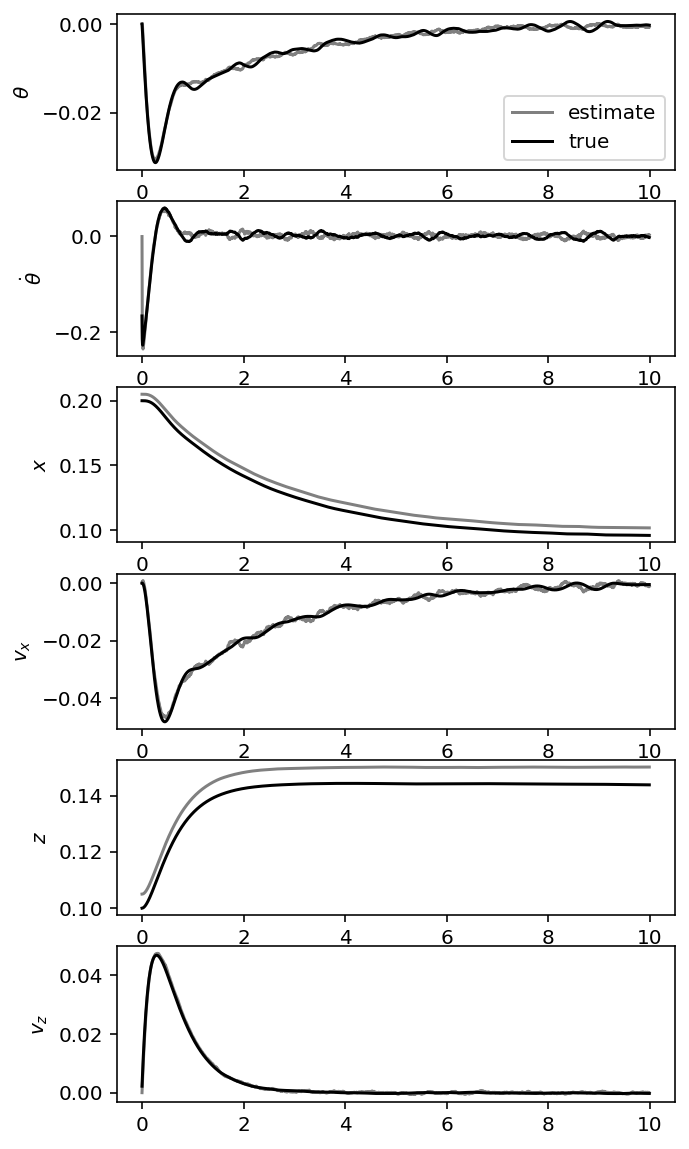

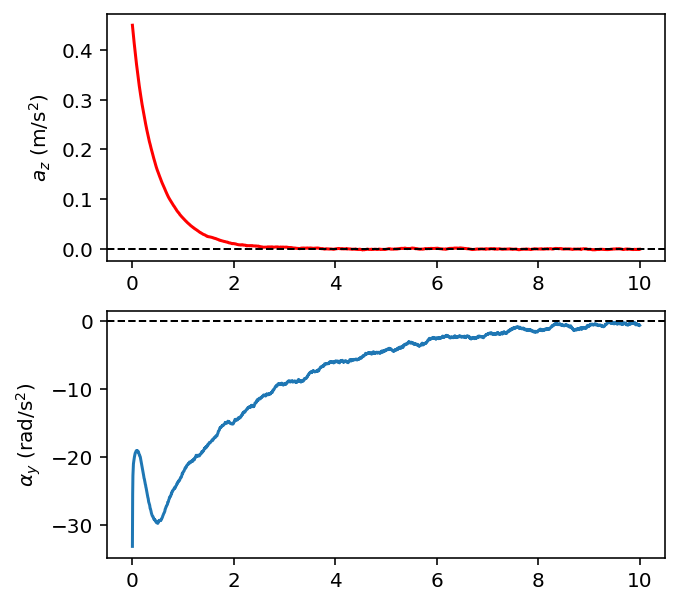

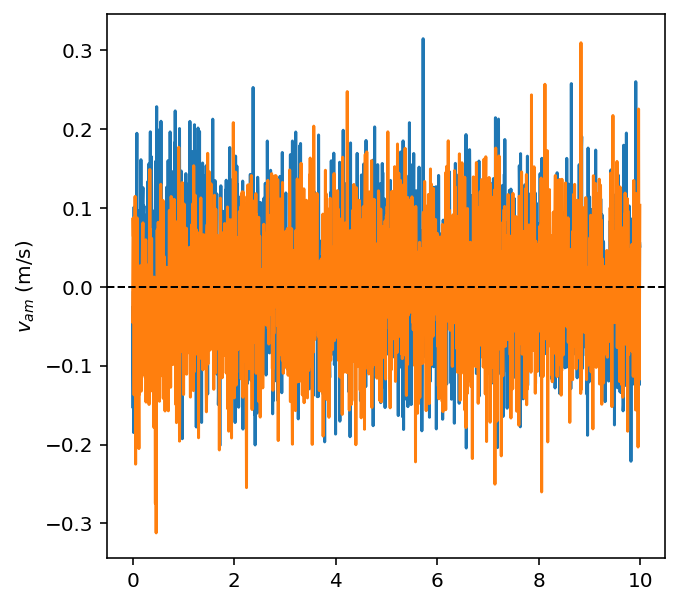

In [43]:
time, q_data, u_data, y_data, qhat_data = simulate(
             q = array([     0,      0, .2,  0, .1,  0]), 
             sensor_model=ideal_a_sensor_model, 
             dynamics_model=nowind_dynamics_model,)
figlist = plot_trajectory(p, time, q_data, u_data, y_data, qhat_data, 
                figure_file='accelerometer_2Dtrajectory.pdf');
figlist[0].text(0,1, '(A)', verticalalignment='top');
figlist[0].savefig('accelerometer_2Dtrajectory.pdf')

# 2. Simulation of accelerometer-optic flow (AO) sensor suite

create linearized dynamics and observer model matrices

In [26]:
# states:  [thetay,      omegay,    x,             vx,   z,       vz,            vwx]
A_ao = \
    array([[0,                1,    0,              0,   0,        0,              0], # thetay
           [0,         -p.c/p.J,    0, -p.b*p.d_z/p.J,   0,        0,  p.b*p.d_z/p.J], # omegay
           [0,                0,    0,              1,   0,        0,              0], # x
           [g,   -p.b*p.d_z/p.m,    0,       -p.b/p.m,   0,        0,        p.b/p.m], # vx
           [0,                0,    0,              0,   0,        1,              0], # z
           [0,                0,    0,              0,   0, -p.b/p.m,              0], # vz
           [0,                0,    0,              0,   0,        0,              0]])# vwx
# inputs   az, alphay
B_ao = \
    array([[0,     0], 
           [0,     1], 
           [0,     0],
           [0,     0], 
           [0,     0],
           [1,     0],
           [0,     0]])
C_ao = \
    array([[0,                0,    0,             -1,   0,        0,              1], # x-airspeed
           [0,                0,    0,              0,   0,       -1,              0], # z-airspeed
           [0,               1, 0,-1/p.pos_desired[1],   0,        0,              0]])# OF

LQR controller

In [27]:
# accelerometer-optic flow controller acts on a larger state vector that includes wind vel estimate vwx. 
K_wind = np.hstack((K, np.zeros((2,1))))

# lqr controller adds compensation for wind by tilting the aircraft and adding torque
def lqr_controller_ao(q, p, t):
    q_desired = array((0, 0, p.pos_desired[0], 0, p.pos_desired[1], 0, 0))

    # linear response to wind estimate
    vwx_estimate = q[6]
    delta_thetay = -p.b * vwx_estimate/(p.m * g)           # linear version
    delta_alphay = -p.d_z * p.b * vwx_estimate / p.J          # angular accel added
    
    q_desired += (delta_thetay, 0, 0, 0, 0, 0, 0)
    delta_u = (0, delta_alphay)
    
    q_error = q_desired - q
    u = K_wind @ q_error + delta_u
    return u

In [28]:
print(K_wind)
print(K_wind[abs(K_wind) > 1e-5], "\n num nonzero gains =", len(K_wind[abs(K_wind) > 1e-5]))

[[ 7.79828793e-13  5.46494165e-15  2.53576803e-12  1.32940375e-13
   1.00000000e+01  2.43597177e+00  0.00000000e+00]
 [ 4.42431117e+02  4.60688365e+01  3.16227766e+02 -1.66838192e+02
   3.42449819e-11  5.46494165e-12  0.00000000e+00]]
[  10.            2.43597177  442.43111689   46.06883652  316.22776602
 -166.83819235] 
 num nonzero gains = 6


# Kalman filter/estimator

In [29]:
# A_ao matrix with x and z is not observable: 
print("full obsv matrix rank =", np.linalg.matrix_rank(ct.obsv(A_ao, C_ao)), ", A rank =", A_ao.shape[0]) 

# create a "reduced" linearized model that leaves out x and z because cannot be directly observed
# old states:[thetay,omegay, x, vx, z, vz, vwx]    
# new states in A_r:[thetay,omegay, vx, vz, vwx]    
A_aor = delstates(A_ao, [2, 4])

# disturbance accel input matrix
#      d = [a_x,   a_z,alpha_y, vwd (wind speed variability)] (forces, torques, and wind speed variation)
G_aor = array([[0,     0,      0,   0], 
             [0,     0,      1,   0], 
             [1,     0,      0,   0],
             [0,     1,      0,   0], 
             [0,     0,      0,   1]])
C_aor = np.delete(C_ao, [2, 4], axis=1)

# sys observable if two ranks are same
print("reduced obsv matrix rank =", np.linalg.matrix_rank(ct.obsv(A_aor, C_aor)), ", A rank =", A_aor.shape[0]) 

# process noise is tuning knob. increase it to rely more on sensors
QN_ao = np.diag((QN_a[0,0], QN_a[1,1], QN_a[2,2], 0.1)) # process noise
RN_ao = np.diag(array((p.sensor_noise_std))**2) # sensor noise
L_ao = ct.lqe(A_aor, G_aor, C_aor, QN_ao, RN_ao, method='scipy')[0]

# now create full estimator, which estimates x and z by numerically integrating vx, vz.
# the noisy velocity estimate means there will be drift in x_world estimate
L_ao = np.vstack((L_ao[:2,:], # first two rows: ty, tdoty 
               [0,0,0], # x
               L_ao[2:3,:], # vx
               [0,0,0], # z
               L_ao[3:,:]))# vz, vwx
print(L_ao)

def estimator_dynamics_ao(qhat, y, u=None):
    if u is None: 
        u = np.zeros(len(B[0]))
    return A_ao @ qhat + B_ao @ u + L_ao @ (y - C_ao @ qhat)

full obsv matrix rank = 5 , A rank = 7
reduced obsv matrix rank = 5 , A rank = 5
[[-2.64448286e-01  3.73488756e-15 -9.41182673e-03]
 [ 1.42953656e+01  3.00573772e-14  1.86401471e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.82438962e+00 -2.58187041e-15 -1.22659446e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.58145285e-15 -1.68900154e-01 -3.09469054e-17]
 [ 1.51675749e-01  1.99958243e-15 -1.05337789e-01]]


In [30]:
print(L_ao[abs(L_ao) > 1e-8], "\n num nonzero gains =", len(L_ao[abs(L_ao) > 1e-8]))

[-2.64448286e-01 -9.41182673e-03  1.42953656e+01  1.86401471e-01
 -1.82438962e+00 -1.22659446e-01 -1.68900154e-01  1.51675749e-01
 -1.05337789e-01] 
 num nonzero gains = 9


simulate

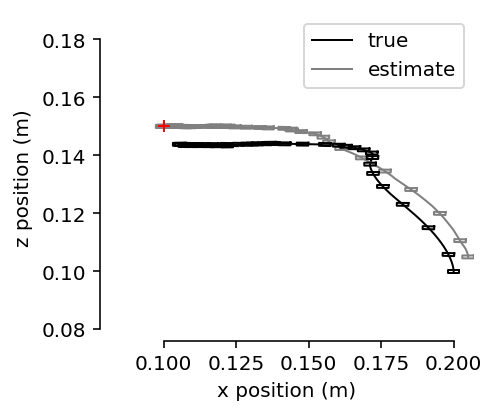

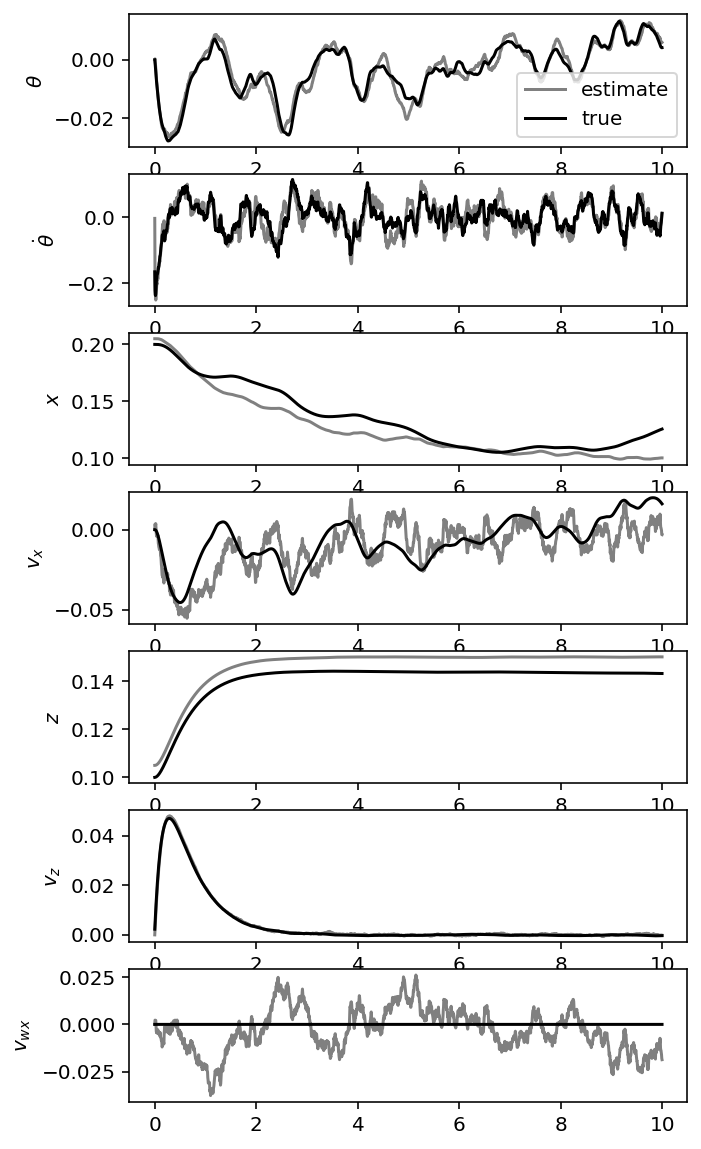

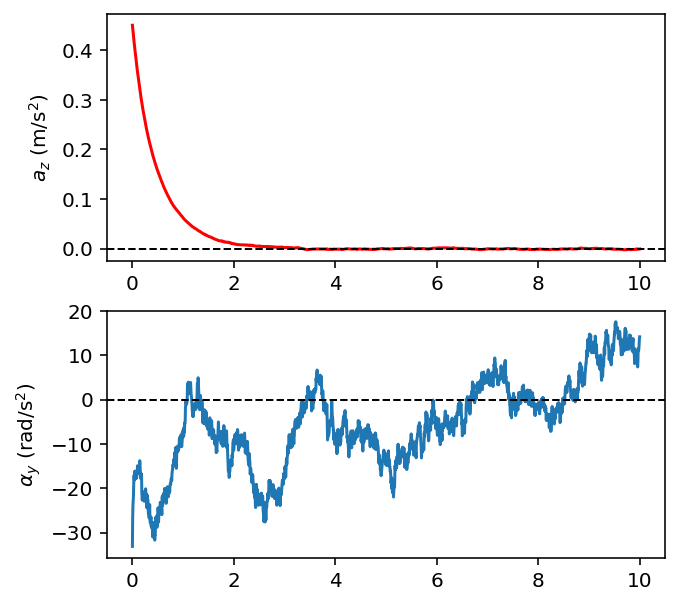

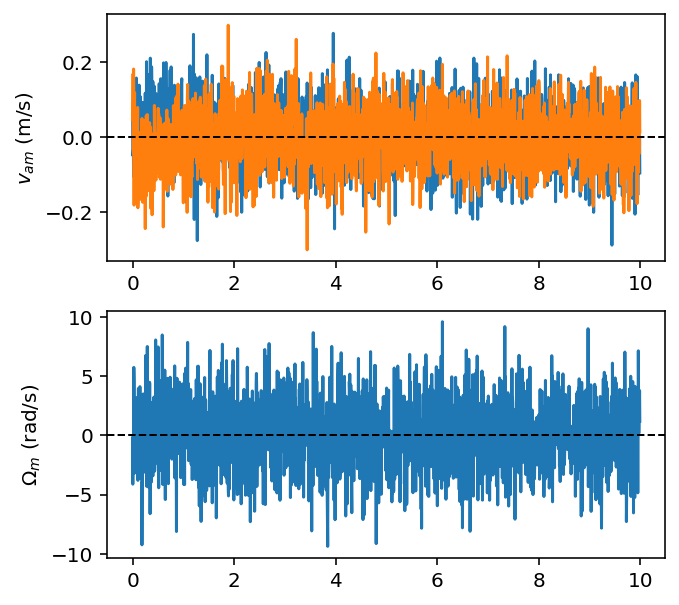

In [31]:
# for reference: plot 2d trajectory with OF feedback, nowind
time, q_data, u_data, y_data, qhat_data = simulate(
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao,
    tfinal=10, use_estimator=True, 
    #         [thetay, omegay,  x, vx,   z, vz, vwx]
    q = array((     0,      0, .2,  0,  .1,  0,   0)))
plot_trajectory(p, time, q_data, u_data, y_data, qhat_data);

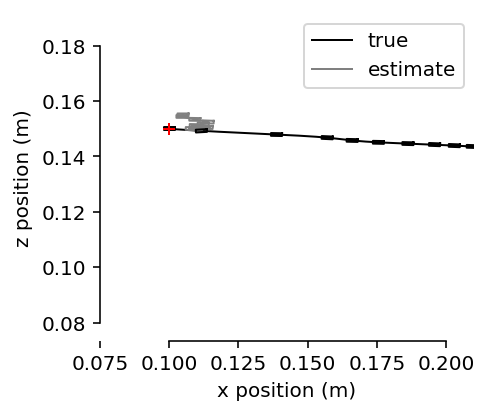

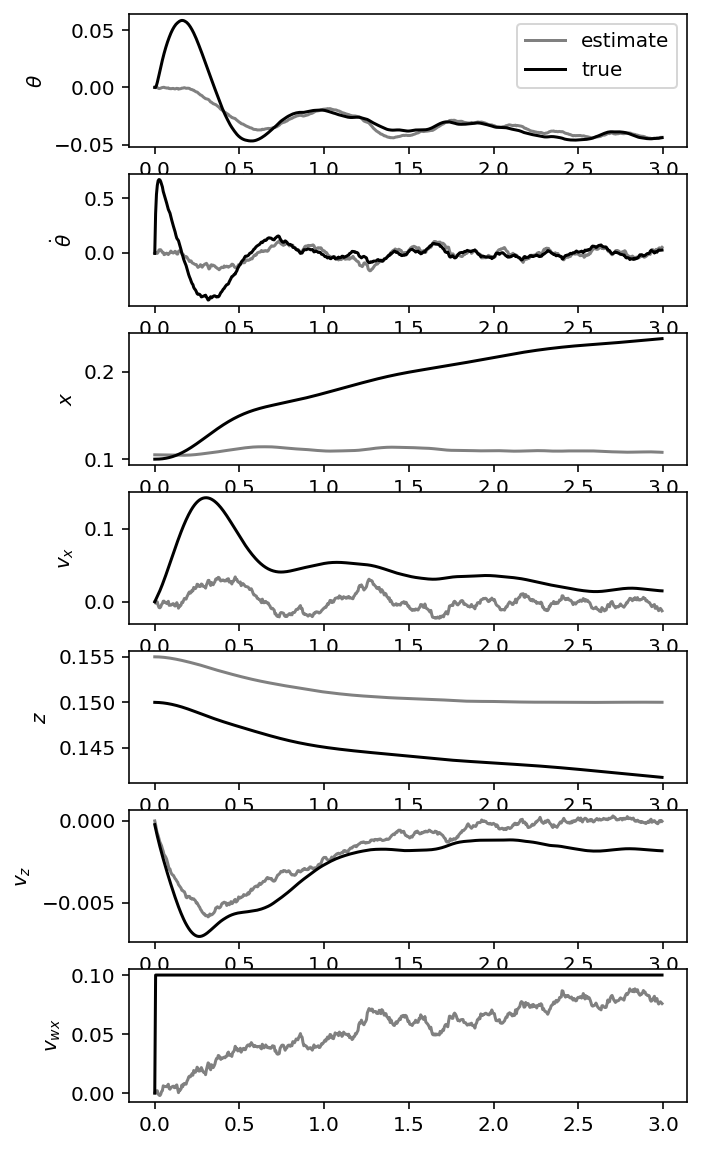

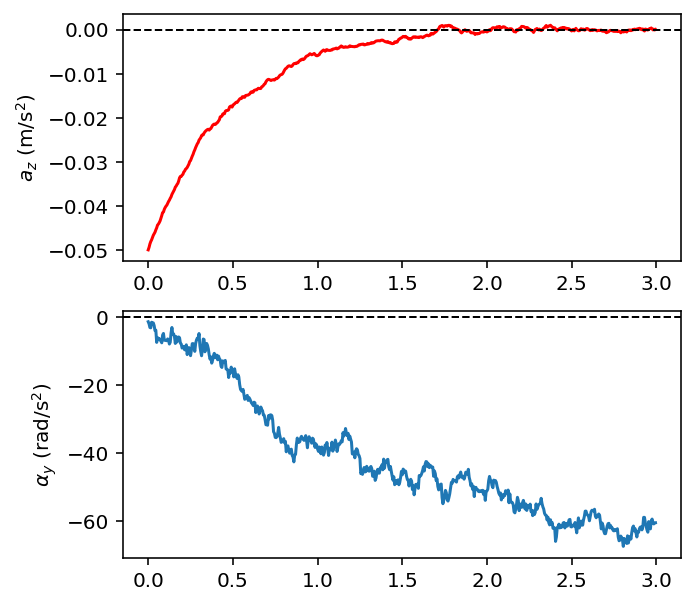

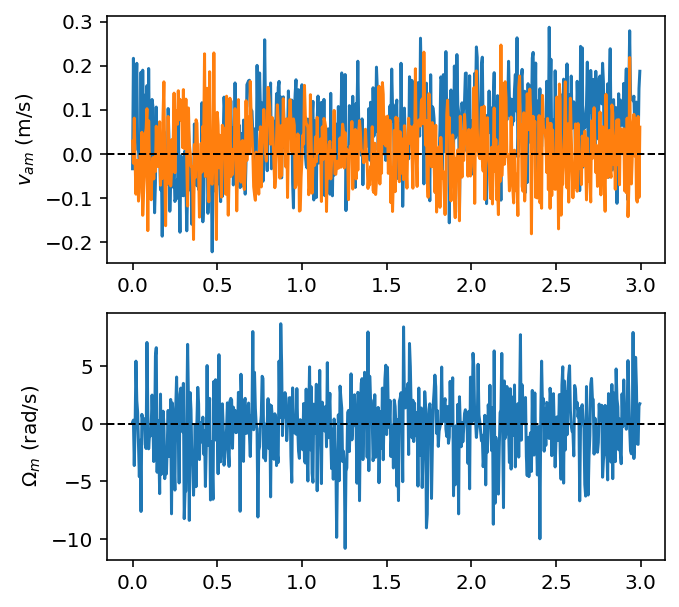

In [32]:
# for reference: wind step response
time, q_data, u_data, y_data, qhat_data = simulate(tfinal=3, 
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao,            
    sensor_model=ideal_ao_sensor_model,                                       
    wind_function=step_wind, 
    #         [thetay, omegay,  x, vx,   z, vz, vwx]
    q = array((     0,      0, .1,  0,  .15,  0,   0)))
plot_trajectory(p, time, q_data, u_data, y_data, qhat_data);

# 3. simulate dynamics with simulated optic flow estimators

In [33]:
# parameters for camera and image texture, position, resolution
moving_average = lambda x, w: np.convolve(x, np.ones(w)/w)
p.image = np.array(loadmat('photo.mat').get('photo')[0], dtype=float)/255-0.5
p.image = moving_average(p.image, 20)
p.image_size = 0.5 # size of image in meters
p.n_gamma = 35 # number of 'pixels'
p.gamma_array = np.linspace(np.deg2rad(-15), np.deg2rad(15), p.n_gamma)
p.dgamma = p.gamma_array[1] - p.gamma_array[0]
p.resolution = p.image_size/len(p.image) # [m/pixel] about 0.0002 for a 2400-length image

functions to simulate optic flow estimation

In [34]:
def ray_casting_snapshot(q, p):
    ''' use ray casting to take a luminance snapshot of the image on the ground below
    q is the state of the robot.
    p is a bunch consisting of parameters for the visual system
    Return: snapshot, the array of the pixel value from the ray casting.
    '''
    theta, x, z = q[[0, 2, 4]]

    # ray intersection    
    angle_array = p.gamma_array + theta        
    angle_array = np.clip(angle_array, np.deg2rad(-90), np.deg2rad(90))
    
    # image is projected on the ground and reflected about origin to double its length
    position_intersection = x - z * np.tan(angle_array)
    position_intersection = np.clip(position_intersection, 
                                    -p.image_size + p.resolution, p.image_size - p.resolution) 

    pixel_indices = np.array(position_intersection/p.resolution, dtype=int)
    snapshot = p.image[pixel_indices]
    return snapshot

def autocorrelator(l, l_previous, dt, dgamma):
    l_t = (l[:-1] - l_previous[:-1])/dt
    l_gamma = (l[1:] - l[:-1])/dgamma
    if autocorrelator.C is None:
        autocorrelator.C = 1 / (l_gamma @ l_gamma)
    return autocorrelator.C * l_gamma @ l_t

def lucas_kanade_1d(l, l_previous, dt, dgamma): 
    l_t = (l[:-1] - l_previous[:-1])/dt
    l_gamma = (l[1:] - l[:-1])/dgamma
    return   l_gamma @ l_t / (l_gamma @ l_gamma)
    
def simulate_ao_from_luminance(t, q, p, v_wind=(0,0), noisy=True):
    ''' simulate sensor readings by estimating optic flow from 
    ray casting snapshots from last two states, q and q_previous 
    '''
    thetay = q[0]
    v_world = q[[3, 5]]
    R2 = R(thetay)
    v_body = R2.T @ v_world
    v_wind_body = R2.T @ v_wind

    if simulate_ao_from_luminance.q_previous is None: 
        simulate_ao_from_luminance.q_previous = q
    l = ray_casting_snapshot(q, p)
    l_previous = ray_casting_snapshot(simulate_ao_from_luminance.q_previous, p)
    
    OF = p.optic_flow_estimator(l, l_previous, DT, p.dgamma) 
    x_airspeed = v_wind_body[0] - v_body[0]  + noisy*normal(0, p.sensor_noise_std[0])
    z_airspeed = v_wind_body[1] - v_body[1]  + noisy*normal(0, p.sensor_noise_std[1])
    
    simulate_ao_from_luminance.q_previous = q.copy()
    return (x_airspeed, z_airspeed, OF)

compare optic flow estimates to true values

do this by disabling the estimator, so the controller uses the true state. This way the trajectories are identical in the three cases we compare: ideal optic flow, Lucas-Kanade, and autocorrelation.

lucas-kanade rmse is 0.044395097047995845
correlator rmse is 0.07428188866861753


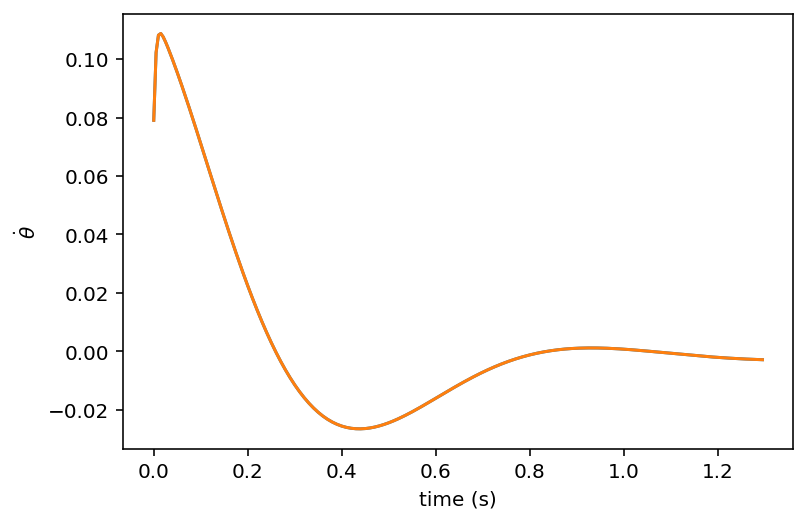

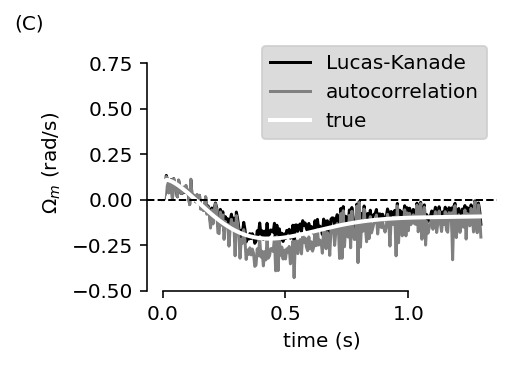

In [36]:
# case 1: save the ideal optic flow value  
time, q_data, u_data, y_data, qhat_data = simulate(
    use_estimator=False, noisy=False, tfinal=1.3, 
    controller=lqr_controller_ao,
    estimator_dynamics=estimator_dynamics_ao,
    sensor_model=ideal_ao_sensor_model,
    q=array(( 0, 0,0.05, 0,.1,  0, 0)))
OF_true = y_data[:,2]

# case 2: lucas-kanade
p.optic_flow_estimator = lucas_kanade_1d
# init state in functions that have memory 
simulate_ao_from_luminance.q_previous = None 
_, q_data_lk, _, y_data, _ = simulate(
    use_estimator=False, tfinal=1.3, 
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao,
    sensor_model=simulate_ao_from_luminance, 
    q=array(( 0, 0,0.05, 0,.1,  0, 0)))
OF_lk = y_data[:,2]

# autocorrelator
p.optic_flow_estimator = autocorrelator
# init state in functions that have memory 
simulate_ao_from_luminance.q_previous = None 
autocorrelator.C = None # init constant
_, q_data_corr, _, y_data, _ = simulate(
    use_estimator=False, tfinal=1.3, 
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao,
    sensor_model=simulate_ao_from_luminance, 
    q=array(( 0, 0,0.05, 0,.1,  0, 0)))
OF_corr = y_data[:,2]

# check
plt.figure()
plt.plot(time, q_data_corr[:,1], time, q_data[:,1])
plt.xlabel('time (s)')
plt.ylabel(r'$\dot \theta$')

fig = plt.figure(figsize=(3.5,2.5))
plt.plot(time, OF_lk, 'k', label='Lucas-Kanade')
plt.plot(time, OF_corr, 'grey', label='autocorrelation')
plt.plot(time, OF_true, 'white', linewidth=2, linestyle='-', label='true')
plt.axhline(0, c='k', ls='--', lw=1)
plt.xlabel('time (s)')
plt.ylim(-.5, .9)
plt.ylabel(r'$\Omega_m$ (rad/s)')
plt.legend(facecolor='lightgrey')
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((-0.5, .75))
ax.spines.bottom.set_bounds((0, 1))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.text(0,1, '(C)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('autocorrelation_vs_lk.pdf')

print('lucas-kanade rmse is', np.linalg.norm(OF_lk - OF_true)/np.sqrt(len(OF_true)))
print('correlator rmse is', np.linalg.norm(OF_corr - OF_true)/np.sqrt(len(OF_true)))

compare 2D trjaectories under full state feedback

In [37]:
def compare_2d_trajectories(p, q_data, qhat_data, color='C0'):
    #plt.plot([0, .2], [0, 0]) # floor
    plt.plot(q_data[::int(0.01/DT),2], q_data[::int(0.01/DT),4], color, lw=1) # trajectory
    plt.plot(qhat_data[::int(0.01/DT),2], qhat_data[::int(0.01/DT),4], 'grey', lw=1) # trajectory
    for q in qhat_data[::int(0.1/DT),:]: # rectangles
        plotfly(q[2], q[4], q[0], p, color='grey')
    for q in q_data[::int(0.1/DT),:]: # rectangles
        plotfly(q[2], q[4], q[0], p, color=color)
    plt.axis('equal')
    plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
    #plt.axis([0, .2, -.01 , 0.2])
    plt.xlabel('x position (m)')
    plt.ylabel('z position (m)')

lucas-kanade position rmse is 0.011087706345653712
correlator position rmse is 0.01865596952794752


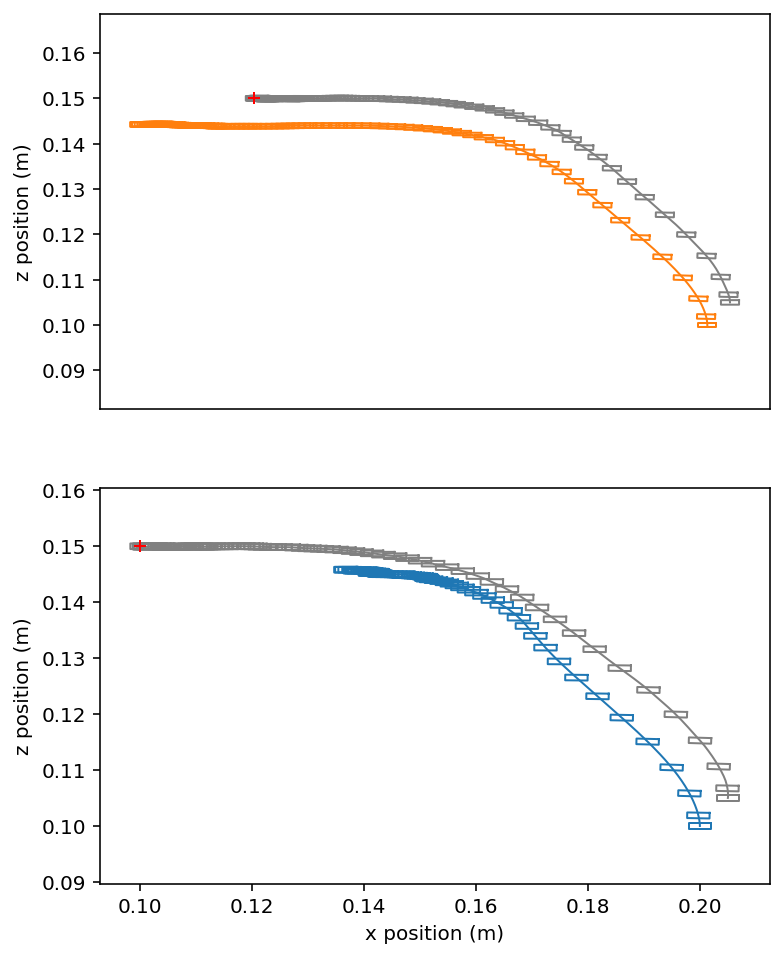

In [38]:
# lucas-kanade
p.optic_flow_estimator = lucas_kanade_1d
# init state in functions that have memory 
simulate_ao_from_luminance.q_previous = None 
_, q_data_lk, _, y_data, qhat_data_lk = simulate(
    sensor_model=simulate_ao_from_luminance,
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao)

# autocorrelator
p.optic_flow_estimator = autocorrelator
# init state in functions that have memory 
simulate_ao_from_luminance.q_previous = None 
autocorrelator.C = None # init constant
time_corr, q_data_corr, _, y_data, qhat_data_corr = simulate(
    sensor_model=simulate_ao_from_luminance,
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao)

plt.figure(figsize=(6,8))
plt.subplot(211)
compare_2d_trajectories(p, q_data_lk, qhat_data_lk, color='C1')
plt.gcf().gca().set_xticks([])
plt.gcf().gca().set_xlabel('')
plt.subplot(212)
compare_2d_trajectories(p, q_data_corr, qhat_data_corr, color='C0')

lk_displacements = np.sqrt(np.mean((qhat_data_lk[:, [2, 4]] - q_data_lk[:, [2, 4]])**2, axis=1))
corr_displacements = np.sqrt(np.mean((qhat_data_corr[:, [2, 4]] - q_data_corr[:, [2, 4]])**2, axis=1))
print('lucas-kanade position rmse is', np.mean(lk_displacements))
print('correlator position rmse is', np.mean(corr_displacements))


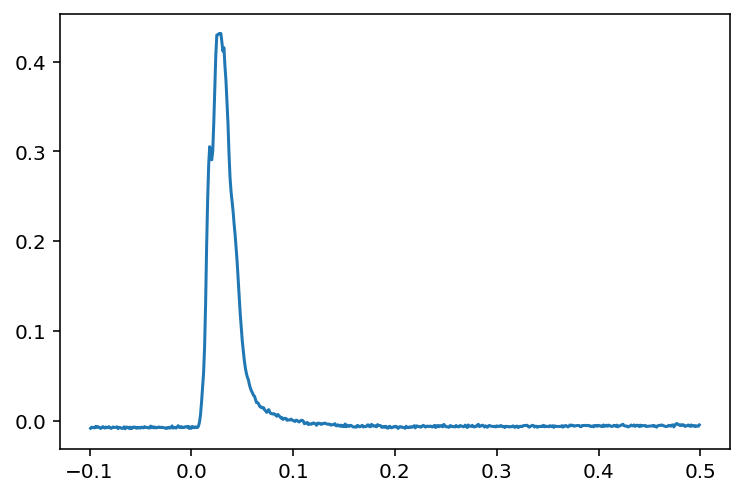

In [39]:
short_gust = np.genfromtxt('15mmgust.txt', delimiter=' ', dtype=None)
long_gust = np.genfromtxt('30mmgust.txt', delimiter=' ', dtype=None)
plt.plot(*short_gust.T);
import scipy as sp
vgust = sp.interpolate.interp1d(short_gust[:,0], -short_gust[:,1], kind='nearest', fill_value='extrapolate')
def impulse_wind(t):
    return (float(vgust(t)), 0)

## step-input gust response for full closed-loop system with autocorrelation optic flow

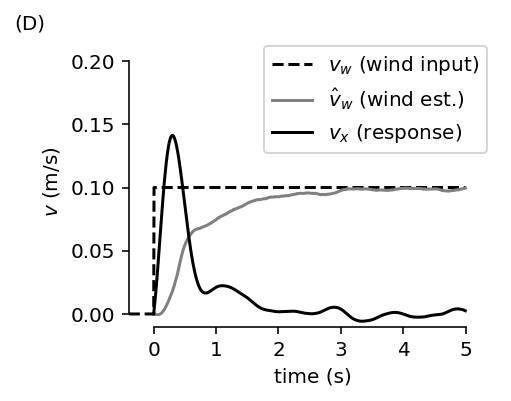

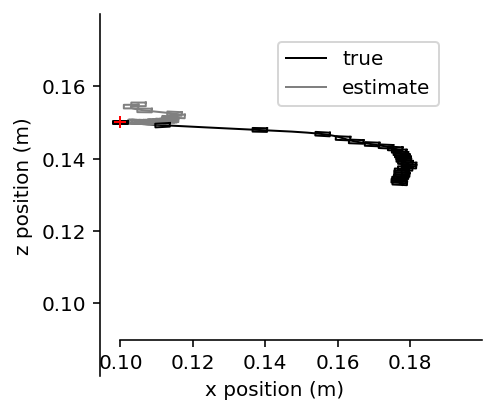

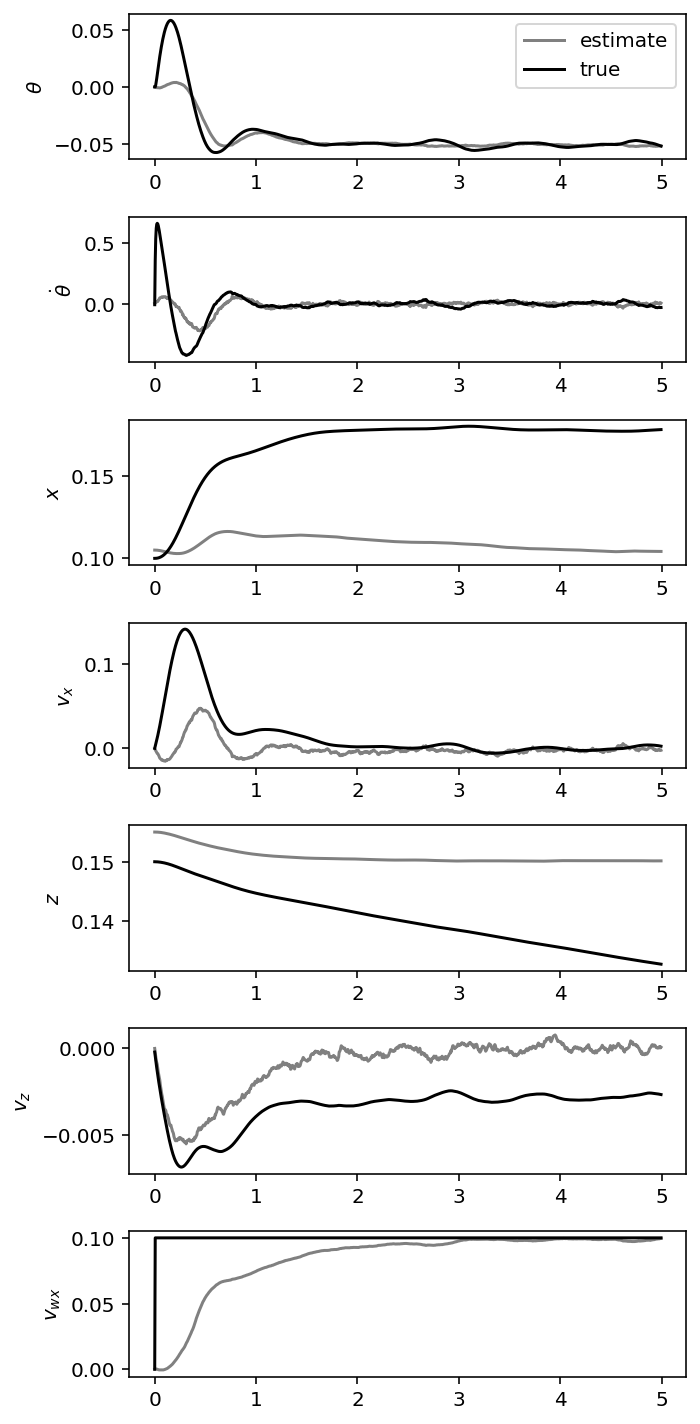

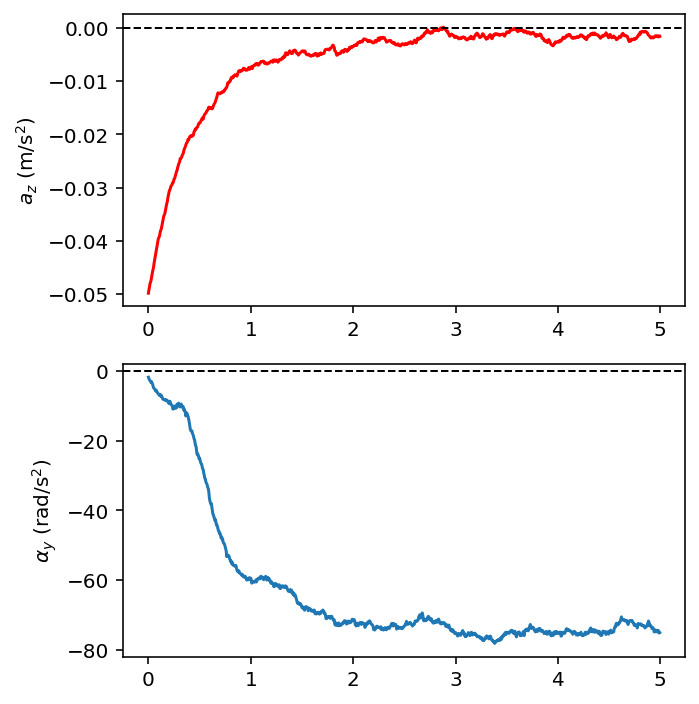

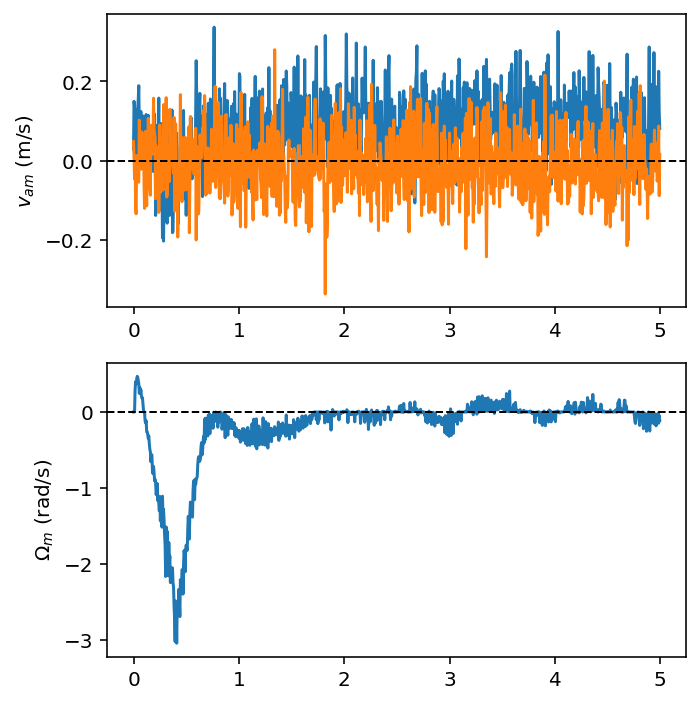

In [40]:
# step response
p.optic_flow_estimator = autocorrelator
# init state in functions that have memory 
autocorrelator.C = None # init constant
simulate_ao_from_luminance.q_previous = None 
time_corr_gust, q_data_corr_gust, u_data_corr_gust, y_data_corr_gust, qhat_data_corr_gust = simulate(
    sensor_model=simulate_ao_from_luminance, 
    controller=lqr_controller_ao, 
    estimator_dynamics=estimator_dynamics_ao,
    wind_function=step_wind,
    tfinal=5, 
    q=array([0, 0, .10, 0, .15, 0, 0]))

fig = plt.figure(figsize=(3.5, 2.75))
vx = q_data_corr_gust[:,3]
vw = q_data_corr_gust[:,6]
vw_hat = qhat_data_corr_gust[:,6]
plt.plot(np.hstack((-.4, 0, time_corr_gust)), np.hstack((0,0, vw)), 'k--', label=r'$v_w$ (wind input)')
plt.plot(time_corr_gust, vw_hat, 'grey', label=r'$\hat v_w$ (wind est.)')
plt.plot(time_corr_gust, vx, 'k', label=r'$v_x$ (response)')
plt.xlabel('time (s)')
plt.ylabel(r'$v$ (m/s)')
plt.legend(loc='upper right')
plt.xlim(-.4, 5.5)
plt.ylim(-.01, .22)
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((0., .2))
ax.spines.bottom.set_bounds((0, 5))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.text(0,1, '(D)', verticalalignment='top') 
plt.tight_layout()
plt.savefig('step_response.pdf');

figlist = plot_trajectory(p, time_corr_gust, q_data_corr_gust, u_data_corr_gust, y_data_corr_gust, qhat_data_corr_gust)
figlist[1].tight_layout()
figlist[1].savefig('step_gust_states.pdf')
figlist[2].tight_layout()
figlist[2].savefig('step_gust_commands.pdf')
figlist[3].tight_layout()
figlist[3].savefig('step_gust_measurements.pdf')


# 4. compare wind impulse response to fruit fly

for this simulation, we will use an aircraft with the same $b/m$ ratio as the fruit fly because that has a big effect on the gust response.

In [41]:
class p2: pass # parameters for a gnat bot with similar damping to a fruit fly
p2.h = 0.001 # height of body [m]
p2.l = .004 # length of body [m]
p2.m = m_gnatbot # mass [kg]
p2.J = p2.m * p2.l**2 / 12 # J for a thin rod of length l [kgm^2]
p2.b = b_drosophila * m_gnatbot/m_drosophila # aero drag on wings 
p2.d_z = 0.0003 # z-distance from ctr of wings to ctr of mass [m]     
p2.winglength = 4.6e-3 # [m]
p2.c = (p2.l/2 + p2.winglength * 2./3)**2 * p2.b   # rot drag coeff around y axis [Nsm]

p2.pos_desired = (.1, .15) # [x_world, z_world]
p2.sensor_noise_std = (gnatbot_sigma_ms, gnatbot_sigma_ms, 3) # [accel_x, accel_z, optic flow] 
print(f'{p2.b = }')
p2.image = p.image
p2.image_size = 0.5 # size of image in meters
p2.n_gamma = 35 # number of 'pixels'
p2.gamma_array = np.linspace(np.deg2rad(-15), np.deg2rad(15), p.n_gamma)
p2.dgamma = p.gamma_array[1] - p.gamma_array[0]
p2.resolution = p.image_size/len(p.image) # [m/pixel] about 0.0002 for a 2400-length image

p2.b = 0.0001



  10
------
s + 10



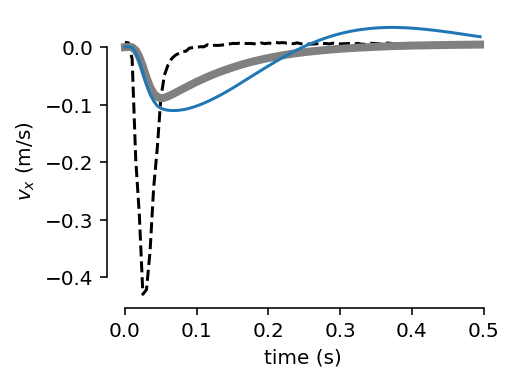

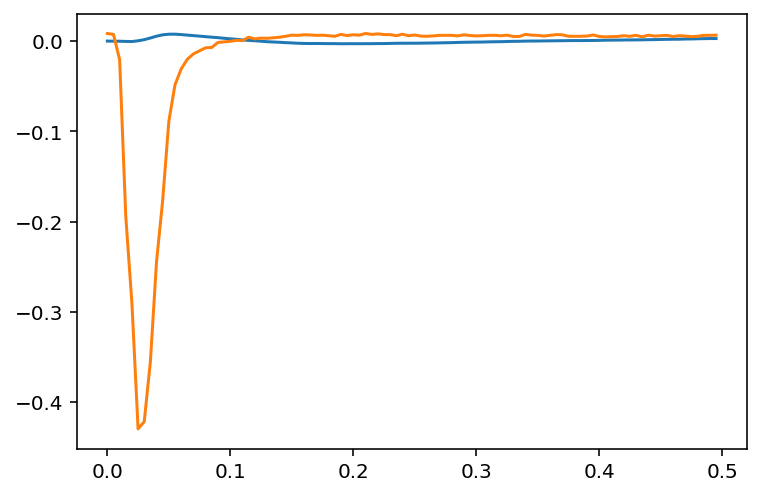

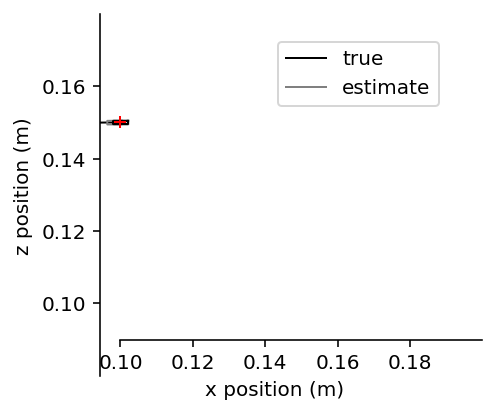

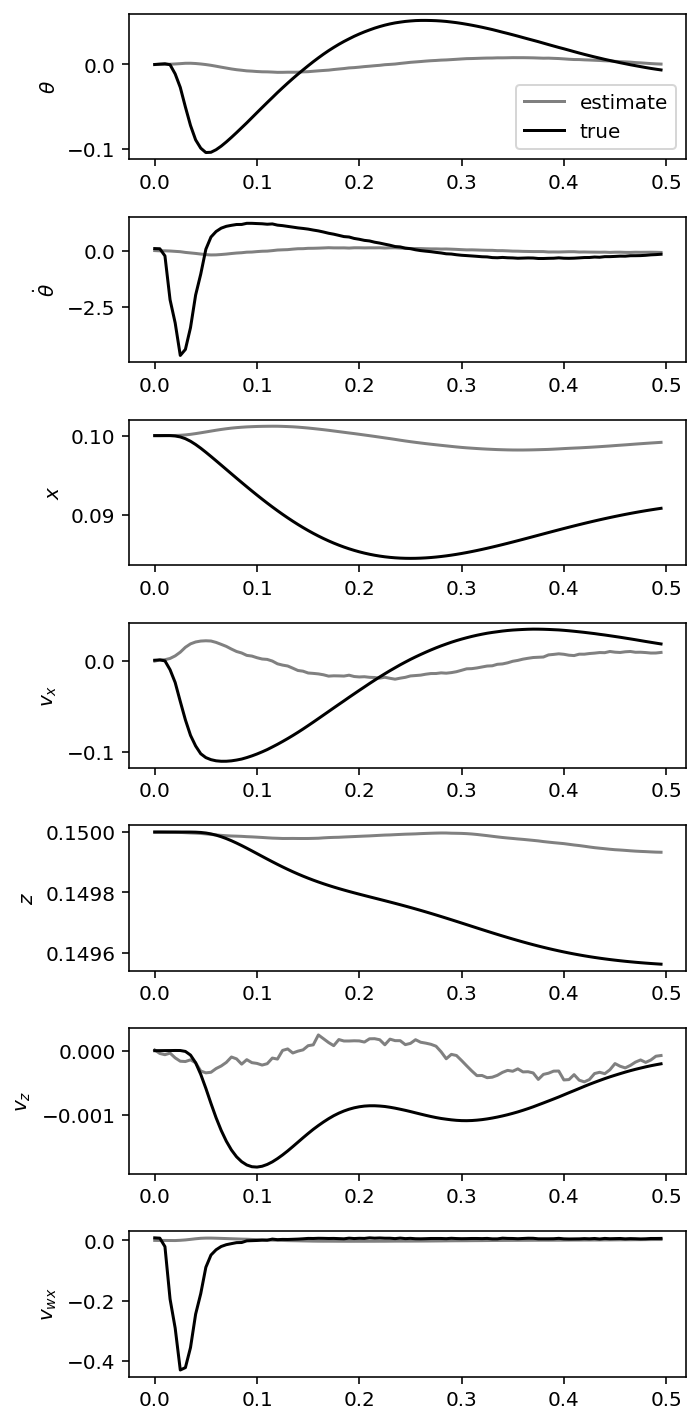

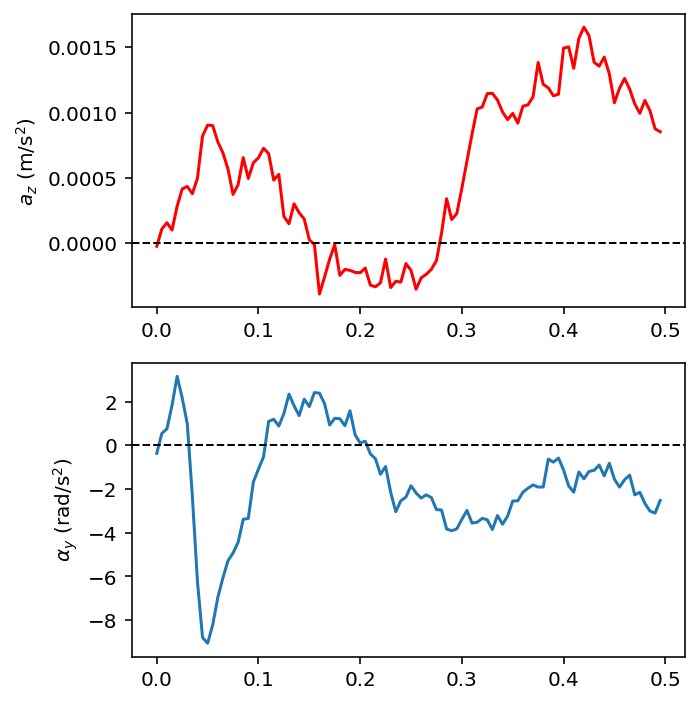

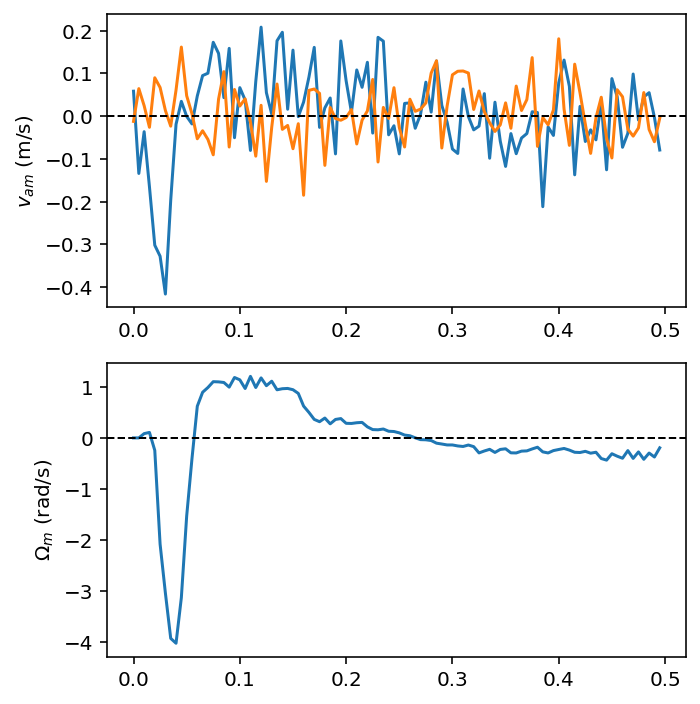

In [42]:
# impulsive gust
plt.figure(figsize=(3.5, 2.7))
p2.optic_flow_estimator = autocorrelator
autocorrelator.C = None # init constant
simulate_ao_from_luminance.q_previous = None 
time_corr_gust, q_data_corr_gust, u_data_corr_gust, y_data_corr_gust, qhat_data_corr_gust = simulate(
        p=p2,
        sensor_model=simulate_ao_from_luminance, 
        controller=lqr_controller_ao, 
        estimator_dynamics=estimator_dynamics_ao,
        wind_function=impulse_wind, 
        tfinal=0.5, 
        q=array([0, 0, .1, 0, .15, 0, 0]), perturb_qhat=False)
plt.plot(time_corr_gust, vgust(time_corr_gust), 'k--')
passive = ct.tf(p2.b/p2.m, [1, p2.b/p2.m])
print(passive) # time constant is about 0.1. 
vw_input = vgust(time_corr_gust)
plt.plot(*ct.forced_response(passive, time_corr_gust, vw_input), linewidth=4, color='grey')

vx = q_data_corr_gust[:,3]
plt.plot(time_corr_gust, vx)
plt.xlabel('time (s)')
plt.ylabel(r'$v_x$ (m/s)');
ax = plt.gca()
# Only draw spine between the y-ticks
ax.spines.left.set_bounds((-.4, 0))
ax.spines.bottom.set_bounds((0, .5))
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('impulse_velocity_response.svg')


# misc plots

# show wind velocity estimate
plt.figure()
vwx_estimate = qhat_data_corr_gust[:,6]
plt.plot(time_corr_gust, vwx_estimate, time_corr_gust, vgust(time_corr_gust))

figlist = plot_trajectory(p, time_corr_gust, q_data_corr_gust, u_data_corr_gust, y_data_corr_gust, qhat_data_corr_gust)
figlist[1].tight_layout()
figlist[1].savefig('gust_states.pdf')
figlist[2].tight_layout()
figlist[2].savefig('gust_commands.pdf')
figlist[3].tight_layout()
figlist[3].savefig('gust_measurements.pdf')
